<a href="https://colab.research.google.com/github/viomn/Heart_Disease_Prediction/blob/main/Disaster_Alert_System_Project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

# Load datasets
earthquake_df = pd.read_csv("/content/drive/MyDrive/BVP_datasets/all_month.csv")
flood_df = pd.read_csv("/content/drive/MyDrive/BVP_datasets/flood.csv (1).zip")



**TRAIN EARTHQUAKE CLASSIFIER**

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Select features
eq_df = earthquake_df[['latitude', 'longitude', 'mag', 'depth']].dropna()
eq_df['label'] = eq_df['mag'].apply(lambda x: 1 if x >= 4.5 else 0)  # 1 = earthquake

X_eq = eq_df[['latitude', 'longitude', 'mag', 'depth']]
y_eq = eq_df['label']

X_train_eq, X_test_eq, y_train_eq, y_test_eq = train_test_split(X_eq, y_eq, test_size=0.2)

eq_model = RandomForestClassifier()
eq_model.fit(X_train_eq, y_train_eq)

print(classification_report(y_test_eq, eq_model.predict(X_test_eq)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2055
           1       1.00      1.00      1.00       113

    accuracy                           1.00      2168
   macro avg       1.00      1.00      1.00      2168
weighted avg       1.00      1.00      1.00      2168



**TRAIN FLOOD REGRESSOR**

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Drop target and nulls
flood_df.dropna(inplace=True)
X_flood = flood_df.drop("FloodProbability", axis=1)
y_flood = flood_df["FloodProbability"]

X_train_flood, X_test_flood, y_train_flood, y_test_flood = train_test_split(X_flood, y_flood, test_size=0.2)

flood_model = RandomForestRegressor()
flood_model.fit(X_train_flood, y_train_flood)

print("MSE:", mean_squared_error(y_test_flood, flood_model.predict(X_test_flood)))

MSE: 0.0006720436592500003


In [6]:
import joblib

joblib.dump(eq_model, "earthquake_model.pkl")
joblib.dump(flood_model, "flood_model.pkl")
joblib.dump(X_flood.columns, "flood_features.pkl")  # save feature order

['flood_features.pkl']

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datetime import datetime

# 1. Load Earthquake Data
earthquake_df = pd.read_csv("/content/drive/MyDrive/BVP_datasets/all_month.csv")
earthquake_df['date'] = pd.to_datetime(earthquake_df['time']).dt.date

# Group by date: if any quake > 4.5 happened, mark as 'Earthquake'
earthquake_event = earthquake_df[earthquake_df['mag'] >= 4.5]
earthquake_by_date = earthquake_event.groupby('date').size().reset_index(name='EarthquakeCount')
earthquake_by_date['Disaster'] = 'Earthquake'
earthquake_by_date['date'] = pd.to_datetime(earthquake_by_date['date'])

# 2. Load and Simulate Flood Data
flood_df = pd.read_csv("/content/drive/MyDrive/BVP_datasets/flood.csv (1).zip")  # already cleaned version
# Simulate 100 dates for the flood data
flood_dates = pd.date_range(start="2025-01-01", periods=100, freq='7D')
flood_df = flood_df.head(100).copy() # Take only the first 100 rows to match the dates
flood_df['date'] = flood_dates
flood_df['Disaster'] = np.where(flood_df['FloodProbability'] > 0.5, 'Flood', 'None')
flood_df['date'] = pd.to_datetime(flood_df['date'])


# 3. Merge both earthquake and flood data
merged_df = pd.merge(flood_df[['date', 'Disaster']], earthquake_by_date[['date', 'Disaster']],
                     on='date', how='outer', suffixes=('_flood', '_eq'))

# Resolve conflicts
def resolve_disaster(row):
    if row['Disaster_eq'] == 'Earthquake':
        return 'Earthquake'
    elif row['Disaster_flood'] == 'Flood':
        return 'Flood'
    elif row['Disaster_flood'] == 'None':
        return 'None'
    else:
        return 'None'

merged_df['FinalDisaster'] = merged_df.apply(resolve_disaster, axis=1)

# Add features (month, day, weekday)
merged_df['month'] = pd.to_datetime(merged_df['date']).dt.month
merged_df['day'] = pd.to_datetime(merged_df['date']).dt.day
merged_df['weekday'] = pd.to_datetime(merged_df['date']).dt.weekday

# Final data for training
X = merged_df[['month', 'day', 'weekday']]
y = merged_df['FinalDisaster']

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 0: Earthquake, 1: Flood, 2: None

# 4. Train-test split & model
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 6. Predict from user input
def predict_disaster(input_date_str):
    input_date = pd.to_datetime(input_date_str)
    features = pd.DataFrame({
        'month': [input_date.month],
        'day': [input_date.day],
        'weekday': [input_date.weekday()]
    })
    pred = model.predict(features)
    return le.inverse_transform(pred)[0]

# Example Usage:
print("Prediction for 2025-01-1:", predict_disaster("2025-01-1"))

Classification Report:
              precision    recall  f1-score   support

  Earthquake       0.83      0.83      0.83         6
       Flood       0.50      0.67      0.57         9
        None       0.62      0.45      0.53        11

    accuracy                           0.62        26
   macro avg       0.65      0.65      0.64        26
weighted avg       0.63      0.62      0.61        26

Prediction for 2025-01-1: Flood


In [9]:
# Define a placeholder function for sending email alerts
def send_email_alert(disaster_type, date):
    print(f"ALERT: Predicted {disaster_type} on {date}. Sending email alert...")
    # Replace this with your actual email sending code

# 1. Predict disaster from input date
disaster = predict_disaster("2025-08-15")

# 2. If it's Flood or Earthquake → Send alert
if disaster != "None":
    send_email_alert(disaster, "2025-08-15")

ALERT: Predicted Earthquake on 2025-08-15. Sending email alert...


In [10]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Step 1: Prediction Function (already defined earlier)
def predict_disaster(input_date_str):
    input_date = pd.to_datetime(input_date_str)
    features = pd.DataFrame({
        'month': [input_date.month],
        'day': [input_date.day],
        'weekday': [input_date.weekday()]
    })
    pred = model.predict(features)
    return le.inverse_transform(pred)[0]

# Step 2: Email Alert Function
def send_email_alert(disaster_type, date_str):
    sender_email = "palakaggarwal9711@gmail.com"        # your Gmail
    receiver_email = "nehandls6@gmail.com"  # receiver
    app_password = "sxhc gxfl zgls uiei"           # NOT your Gmail password!

     # --- Precautions dictionary ---
    precautions = {
        "Earthquake": """
        🛑 Earthquake Safety Tips:
        - Drop, Cover, and Hold On during shaking.
        - Stay away from windows, mirrors, and glass.
        - If you're outside, move to an open area away from buildings.
        - Keep an emergency kit with water, flashlight, batteries, etc.
        - Avoid elevators and stay calm.
        """,
        "Flood": """
        🌊 Flood Safety Tips:
        - Move to higher ground immediately.
        - Avoid walking or driving through floodwaters.
        - Disconnect electrical appliances and turn off gas.
        - Keep emergency contacts and important documents ready.
        - Follow official evacuation orders if announced.
        """
    }

    # Check and show precautions
    if disaster_type in precautions:
        print("⚠️ Disaster Detected:", disaster_type)
        print(precautions[disaster_type])
    else:
        print("✅ No disaster predicted. Stay safe!")


    subject = f"🚨 Alert: {disaster_type} predicted on {date_str}"
    body = f"""
Hi there,

Our system has detected a possible {disaster_type.upper()} on {date_str}.
Please stay alert and follow safety instructions.

Regards,
Disaster Prediction System
"""

    msg = MIMEMultipart()
    msg["From"] = sender_email
    msg["To"] = receiver_email
    msg["Subject"] = subject
    msg.attach(MIMEText(body, "plain"))

    # Send email via Gmail SMTP
    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, app_password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()
        print("✅ Email sent successfully!")
    except Exception as e:
        print("❌ Failed to send email:", e)

# Step 3: Use both functions
input_date = "2025-10-30"
prediction = predict_disaster(input_date)
print("Predicted:", prediction)

if prediction != "None":
    send_email_alert(prediction, input_date)

Predicted: Flood
⚠️ Disaster Detected: Flood

        🌊 Flood Safety Tips:
        - Move to higher ground immediately.
        - Avoid walking or driving through floodwaters.
        - Disconnect electrical appliances and turn off gas.
        - Keep emergency contacts and important documents ready.
        - Follow official evacuation orders if announced.
        
✅ Email sent successfully!


In [11]:
pip install streamlit pandas matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


2025-07-23 06:00:27.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:27.978 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:27.979 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:27.980 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:27.981 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:27.982 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:27.983 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:27.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

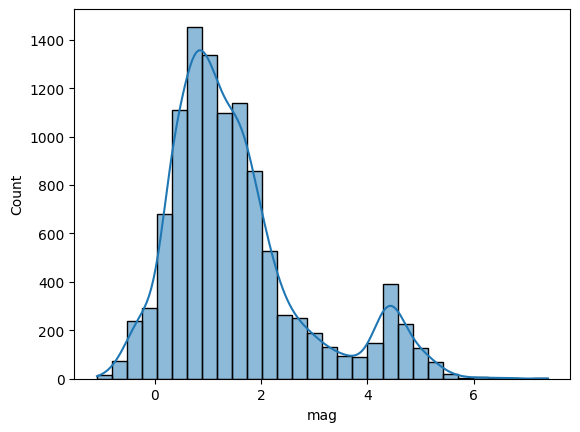

In [13]:
import streamlit as st
import pandas as pd
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(page_title="Disaster Data Explorer", layout="wide")

st.title("🌍 Disaster Data Dashboard")

# Sidebar selection
disaster_type = st.sidebar.selectbox("Select Disaster Type", ["Earthquake", "Flood"])

# Function to load earthquake data
@st.cache_data
def load_earthquake_data():
    df = pd.read_csv("/content/drive/MyDrive/BVP_datasets/all_month.csv")
    return df

# Function to load flood data from zip
@st.cache_data
def load_flood_data():
    with zipfile.ZipFile("flood.csv.zip", 'r') as zip_ref:
        for filename in zip_ref.namelist():
            with zip_ref.open(filename) as f:
                return pd.read_csv(f)

# Load selected data
if disaster_type == "Earthquake":
    df = load_earthquake_data()
    st.subheader("📊 Earthquake Data Preview")
    st.dataframe(df.head())

    st.subheader("Magnitude Distribution")
    fig, ax = plt.subplots()
    sns.histplot(df['mag'].dropna(), kde=True, bins=30, ax=ax)
    st.pyplot(fig)

    st.write("Total Earthquakes:", len(df))
    st.write("Max Magnitude:", df['mag'].max())

elif disaster_type == "Flood":
    df = load_flood_data()
    st.subheader("📊 Flood Data Preview")
    st.dataframe(df.head())

    st.subheader("Flood Data Summary")
    st.write(df.describe())

# Optional: show raw data
with st.expander("🔍 Show Raw Data"):
    st.dataframe(df)


**Earthquake Using Map**

In [14]:
st.subheader("🌐 Earthquake Locations Map")

# Ensure lat/long columns are valid
if 'latitude' in df.columns and 'longitude' in df.columns:
    st.map(df[['latitude', 'longitude']].dropna())
else:
    st.warning("Latitude and Longitude not found in earthquake dataset.")


2025-07-23 06:00:43.786 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:43.788 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:43.788 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:43.889 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:43.891 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:43.894 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


**Flood Data Using Map**

In [15]:
import pydeck as pdk

st.subheader("🌐 Flood Map (Interactive)")

if 'latitude' in df.columns and 'longitude' in df.columns:
    df_clean = df[['latitude', 'longitude']].dropna()

    # Optional: use other columns like 'severity' or 'depth' for radius/tooltip
    layer = pdk.Layer(
        "ScatterplotLayer",
        data=df_clean,
        get_position='[longitude, latitude]',
        get_radius=10000,
        get_fill_color='[0, 100, 255, 160]',
        pickable=True,
    )

    view_state = pdk.ViewState(
        latitude=df_clean['latitude'].mean(),
        longitude=df_clean['longitude'].mean(),
        zoom=4,
        pitch=0,
    )

    st.pydeck_chart(pdk.Deck(
        map_style='mapbox://styles/mapbox/light-v9',
        initial_view_state=view_state,
        layers=[layer],
        tooltip={"text": "Lat: {latitude}\nLon: {longitude}"}
    ))
else:
    st.warning("Flood dataset doesn't have latitude/longitude columns.")


2025-07-23 06:00:50.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:50.263 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:50.265 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:50.296 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:50.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:50.409 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:50.411 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [16]:
if disaster_type == "Earthquake":
    ...
    # Add this
    st.subheader("🌐 Earthquake Map View")
    if 'latitude' in df.columns and 'longitude' in df.columns:
        st.map(df[['latitude', 'longitude']].dropna())
elif disaster_type == "Flood":
    ...
    # Add this
    st.subheader("🌐 Flood Map View")
    if 'latitude' in df.columns and 'longitude' in df.columns:
        ...
        # pydeck chart code


2025-07-23 06:00:59.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:59.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:59.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:59.777 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:59.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 06:00:59.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [17]:
pip install pydeck
